---
layout: page
title: Inflation and Interest Rates
---

In [17]:
""" import library and package dependencies """
import sys
sys.path.insert(0, '../src')
import os
import datetime
import pytz
from collections import namedtuple
from urllib.parse import quote
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from IPython.display import display, Markdown

from data_loader import load_csv_data, get_last_publish_date
from chart_format import StandardChart, PercentileChart

## [Inflation](inflation.html)

The Consumer Price Index that the Reserve Bank of Australia use to index inflation is published quarterly, one month after the end of each quarter.

See [inflation](inflation.html) for inflation charts, trends and analysis.

## [Interest Rates](interest-rates.html)

The Housing Loan Lending Rates are set by the Reserve Bank of Australia and published monthly within five business days after month end.

See [interest rates](interest-rates.html) for interest rate charts, trends and analysis.

## Inflation and Interest Rates

In [18]:
""" Load dataframes from other notebooks """
df_inflation = pd.DataFrame()
df_interest = pd.DataFrame()
%store -r df_inflation
%store -r df_interest

In [19]:
""" Chart variables """
start_date = pd.to_datetime('1960-01-01')
end_date = pd.to_datetime('2025-01-01') # used to force chart to plot to end of 5 year period
df_interest = df_interest.loc[df_interest.index >= start_date]
df_inflation = df_inflation.loc[df_inflation.index >= start_date]
interest_column = 'FILRHLBVS'
inflation_column = 'GCPIAGYP'
# Set 'last_index' to the last date with a valid value (so I can display 'as of <date>' in chart title)
last_index = df_interest[interest_column].last_valid_index()

In [20]:
def add_horizontal_band(plt, legend_location='best'):
    # Add a horizontal band between y=2 and y=3
    plt.fill_between(df_inflation.index, 2, 3, color=colors[1]['color'], alpha=0.1)
    # Create a Patch for the legend
    target_range = mpatches.Patch(color=colors[1]['color'], alpha=0.1, label='Target Inflation Range')
    # Get the existing legend entries
    ax = plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    # Add the patch to the existing handles
    handles.append(target_range)
    plt.legend(handles=handles, loc=legend_location)
    return plt

In [21]:
def plot_percentiles(plt, df, percentiles, multi_year=0, color_index=0):
    for i, percentile in enumerate(percentiles._fields):
        linestyle = '--' if i != 1 else '-'
        alpha = 0.7 if i != 1 else 1.0
        if i == 0:
            label = f'{str(percentiles[0]) + "th and " + str(percentiles[2]) + "th Percentile"}'
        elif i == 1:
            label = f'{multi_year} Year {percentile.capitalize()}'
        else:
            label = None
        plt.plot(df.index, df[f'rolling_{multi_year}_years_{percentile}'], color=colors[color_index]['color'], linestyle=linestyle, alpha=alpha, label=label)

The Reserve Bank of Australia has often increased base interest rates alledging a high correlation between interest rates and inflation.

This appears a reasonable construct from basic supply and demand economics; when households have high disposable income, demand for non-essential goods and services increases, and if supply is limited, prices increase to meet demand, resulting in inflation. 

Increasing interest rates reduces disposable income (for those with borrowing debt), thus reducing some demand for non-essential goods and services, potentially resulting in some price reductions, and subsequently reducing inflation.

Is there really a high correlation, or is this over simplification? Do lower interest rates subsequently cause inflation to rise, and higher interest rates subsequently cause inflation to reduce?

Perhaps there are other external factors influencing inflation, such as global oil prices, foreign war, pandemic supply chains, that have nothing to do with household disposable income?

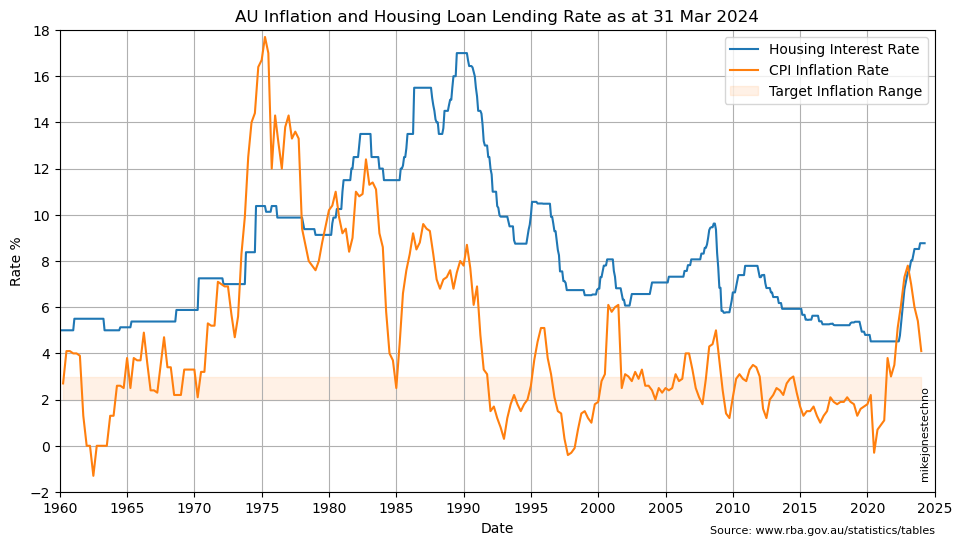

In [22]:
""" Prepare simple chart """

chart_params = {
    'chart_title': 'AU Inflation and Housing Loan Lending Rate as at ' + last_index.strftime('%d %b %Y'), 
    'chart_source': 'Source: www.rba.gov.au/statistics/tables', 
    'y_label': 'Rate %', 
    'y_ticks': 2,
    'x_label': 'Date', 
    'x_ticks': 5,
    'start_year': 1960,
    'data_column': inflation_column
}

standard_chart = StandardChart(**chart_params)
plt, colors = standard_chart.base_chart(df_inflation)

plt.plot(df_interest.index, df_interest[interest_column], color=colors[0]['color'], label='Housing Interest Rate')
plt.plot(df_inflation.index, df_inflation[inflation_column], color=colors[1]['color'], label='CPI Inflation Rate')
legend = plt.legend(loc='best')
legend.get_frame().set_alpha(0.98)
plt = add_horizontal_band(plt)

plt.show()

In [23]:
""" Calculate median 50th and lower, upper percentiles over multiple years """
multi_years = [10, 20, 30]

# Define the percentiles and window sizes
Percentiles = namedtuple('Percentiles', ['lower', 'median', 'upper'])
percentiles = Percentiles(25, 50, 75)